# Restricted Boltzman Machines
Léo Tarbouriech and Joseph Touzet

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import torchviz
from sklearn.decomposition import PCA

In [2]:
def show_and_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.savefig(file_name, dpi=300, bbox_inches='tight')

In [3]:
# this is a descrete RBM
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.relu(torch.sign(p - Variable(torch.rand(p.size()))))

   def v_to_h(self,v):
        p_h      = F.sigmoid(F.linear(v, self.W, self.h_bias))
        sample_h = self.sample_from_p(p_h)
       
        return sample_h
    
   def h_to_v(self,h):
        p_v      = F.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        sample_v = self.sample_from_p(p_v)
       
        return sample_v,p_v

   def forward(self,v):
        h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            v_,p_v = self.h_to_v(h_)
            h_     = self.v_to_h(v_)
        
        return v,v_,p_v

   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

## RBM on AND problem

In [4]:
def truth_func(x, y):
    #return np.logical_xor(x, y)
    return x*y
    #return np.logical_or(x, y)
    #return np.logical_not(x)

def genTraining(N):
    data   = np.random.randint(0, 2, (N, 2))
    target = truth_func(data[:, 0:1], data[:, 1:2])
    return data,target

def concatFlat(data, target):
    concat = np.concatenate((data, target), axis=1).astype(np.single) #.flatten()
    #concat = 2*concat - 1
    return concat

def deConcatFlat(data):
    #data = data.reshape(-1, 3)
    #data = (data + 1)/2
    return data[:, 0:2], data[:, 2:3]

def sucessRate(data, target):
    ground_truth = truth_func(data[:, 0:1], data[:, 1:2])
    return 1 - np.mean(np.abs(target - ground_truth))

### Out of equilibrium - small number of iterations

In [5]:
batch_size = 100
n_it_train_short = 4
rbm_small = RBM(3, 3, k=n_it_train_short)
train_op = optim.SGD(rbm_small.parameters(), 0.1)

losses = []
sucess_rates = []

for epoch in range(15):
    loss_ = []
    sucess_rate_ = []
    for i in range(1000):
        data,target = genTraining(batch_size)
        data_var = Variable(torch.from_numpy(concatFlat(data, target).astype(np.single)))
        
        v,v1,p_v1 = rbm_small(data_var)
        loss = rbm_small.free_energy(v) - rbm_small.free_energy(v1)
        #loss = torch.abs(v - v1).mean()
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        sucess_rate = sucessRate(*deConcatFlat(v1.detach().numpy()))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm_small.v_bias.detach().numpy())
print("h_bias:", rbm_small.h_bias.detach().numpy())
print("W:\n", rbm_small.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.03495654836297035, 64%
Training loss and sucess rate for 1 epoch: -0.092601478099823, 71%
Training loss and sucess rate for 2 epoch: -0.09878938645124435, 78%
Training loss and sucess rate for 3 epoch: -0.09113498032093048, 81%
Training loss and sucess rate for 4 epoch: -0.10346398502588272, 84%
Training loss and sucess rate for 5 epoch: -0.1481165587902069, 89%
Training loss and sucess rate for 6 epoch: -0.14869390428066254, 93%
Training loss and sucess rate for 7 epoch: -0.12071893364191055, 95%
Training loss and sucess rate for 8 epoch: -0.10603775829076767, 96%
Training loss and sucess rate for 9 epoch: -0.08943665772676468, 97%
Training loss and sucess rate for 10 epoch: -0.08064825087785721, 97%
Training loss and sucess rate for 11 epoch: -0.07007287442684174, 97%
Training loss and sucess rate for 12 epoch: -0.06615132093429565, 98%
Training loss and sucess rate for 13 epoch: -0.06311564892530441, 98%
Training loss and sucess rate for

In [6]:
W_eigen_vect  = np.linalg.svd(rbm_small.W.detach().numpy()).Vh.T
W_eigen_vect /= np.abs(W_eigen_vect).sum(1)

data     = concatFlat(*genTraining(1000))
#_,_,data = rbm_small(torch.from_numpy(data))
#data     = data.detach().numpy()

pca = PCA(3)
pca.fit(data)
pc_data  = np.linalg.eig(pca.get_covariance()).eigenvectors
pc_data /= np.abs(pc_data).sum(1)

corr_mat = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        corr_mat[i, j] = abs(W_eigen_vect[i, :].dot(pc_data[j, :]))

for i in range(3):
    idx = np.argmax(corr_mat[i, i:]) + i
    save             = np.copy(corr_mat[idx, :])
    corr_mat[idx, :] =         corr_mat[i,   :]
    corr_mat[i,   :] = save

print(corr_mat.T)

[[0.37385929 0.12852836 0.03521229]
 [0.03230269 0.39024156 0.01827018]
 [0.10231338 0.07029629 0.40213674]]


In [7]:
data,target = genTraining(100)
data_var = Variable(torch.from_numpy(concatFlat(data, target).astype(np.single)))


n_it = 2*n_it_train_short

prob_traj_noFlip = np.zeros((n_it+1, 100))
prob_traj_noFlip[0, :] = np.ones(prob_traj_noFlip.shape[1])

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_noFlip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_noFlip[i+1, ground_truth==0] = 1-prob_traj_noFlip[i+1, ground_truth==0]


data_var[:, 2] = 1 - data_var[:, 2]
prob_traj_flip = np.zeros((n_it+1, 100))

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_flip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_flip[i+1, ground_truth==0] = 1-prob_traj_flip[i+1, ground_truth==0]

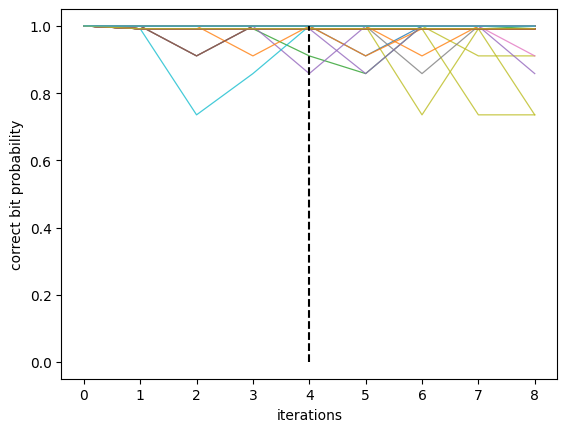

In [8]:
plt.plot(prob_traj_noFlip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train_short, n_it_train_short], [0, 1], "k--")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_stability_short.png')

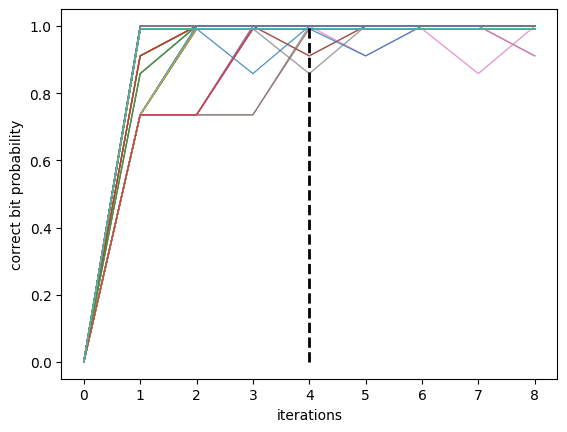

In [9]:
plt.plot(prob_traj_flip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train_short, n_it_train_short], [0, 1], "k--", linewidth=2)

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_correction_short.png')

### At equilibrium - great number of iterations

In [10]:
batch_size = 100
n_it_train_long = 30
rbm_big = RBM(3, 3, k=n_it_train_long)
train_op = optim.SGD(rbm_big.parameters(), 0.1)

losses = []
sucess_rates = []

for epoch in range(15):
    loss_ = []
    sucess_rate_ = []
    for i in range(500):
        data,target = genTraining(batch_size)
        data_var = Variable(torch.from_numpy(concatFlat(data, target).astype(np.single)))
        
        v,v1,p_v1 = rbm_big(data_var)
        loss = rbm_big.free_energy(v) - rbm_big.free_energy(v1)
        #loss = torch.abs(v - v1).mean()
        
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        sucess_rate = sucessRate(*deConcatFlat(v1.detach().numpy()))
        sucess_rate_.append(sucess_rate)

    losses.append(np.mean(loss_))
    sucess_rates.append(np.mean(sucess_rate_))
    print("Training loss and sucess rate for {} epoch: {}, {}%".format(epoch, losses[-1], int(sucess_rates[-1]*100)))
    
print("\nv_bias:", rbm_big.v_bias.detach().numpy())
print("h_bias:", rbm_big.h_bias.detach().numpy())
print("W:\n", rbm_big.W.detach().numpy())

Training loss and sucess rate for 0 epoch: -0.015502342954277992, 62%
Training loss and sucess rate for 1 epoch: -0.057639289647340775, 66%
Training loss and sucess rate for 2 epoch: -0.09085799008607864, 70%
Training loss and sucess rate for 3 epoch: -0.09463825821876526, 74%
Training loss and sucess rate for 4 epoch: -0.1014108955860138, 76%
Training loss and sucess rate for 5 epoch: -0.0977703407406807, 79%
Training loss and sucess rate for 6 epoch: -0.09469828754663467, 81%
Training loss and sucess rate for 7 epoch: -0.09517837315797806, 83%
Training loss and sucess rate for 8 epoch: -0.09574700891971588, 84%
Training loss and sucess rate for 9 epoch: -0.12065009772777557, 86%
Training loss and sucess rate for 10 epoch: -0.15087971091270447, 89%
Training loss and sucess rate for 11 epoch: -0.15384073555469513, 91%
Training loss and sucess rate for 12 epoch: -0.14900001883506775, 93%
Training loss and sucess rate for 13 epoch: -0.13341225683689117, 94%
Training loss and sucess rate 

In [11]:
W_eigen_vect  = np.linalg.svd(rbm_big.W.detach().numpy()).Vh.T
W_eigen_vect /= np.abs(W_eigen_vect).sum(1)

data     = concatFlat(*genTraining(1000))
#_,_,data = rbm_big(torch.from_numpy(data))
#data     = data.detach().numpy()

pca = PCA(3)
pca.fit(data)
pc_data  = np.linalg.eig(pca.get_covariance()).eigenvectors
pc_data /= np.abs(pc_data).sum(1)

corr_mat = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        corr_mat[i, j] = abs(W_eigen_vect[i, :].dot(pc_data[j, :]))

for i in range(3):
    idx = np.argmax(corr_mat[i, i:]) + i
    save             = np.copy(corr_mat[idx, :])
    corr_mat[idx, :] =         corr_mat[i,   :]
    corr_mat[i,   :] = save

print(corr_mat.T)

[[0.21732599 0.08315974 0.3192046 ]
 [0.04235859 0.31716496 0.22714001]
 [0.35414231 0.20202838 0.11308932]]


In [12]:
data,target = genTraining(100)
data_var = Variable(torch.from_numpy(concatFlat(data, target).astype(np.single)))


n_it = 2*n_it_train_long

prob_traj_noFlip = np.zeros((n_it+1, 100))
prob_traj_noFlip[0, :] = np.ones(prob_traj_noFlip.shape[1])

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_noFlip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_noFlip[i+1, ground_truth==0] = 1-prob_traj_noFlip[i+1, ground_truth==0]


data_var[:, 2] = 1 - data_var[:, 2]
prob_traj_flip = np.zeros((n_it+1, 100))

h_ = rbm_small.v_to_h(data_var)
for i in range(n_it):
    v_,p_v = rbm_small.h_to_v(h_)
    h_     = rbm_small.v_to_h(v_)

    data = p_v.detach().numpy()
    prob_traj_flip[i+1, :] = data[:, 2]

    data = np.round(data)
    ground_truth = truth_func(data[:, 1], data[:, 2])
    prob_traj_flip[i+1, ground_truth==0] = 1-prob_traj_flip[i+1, ground_truth==0]

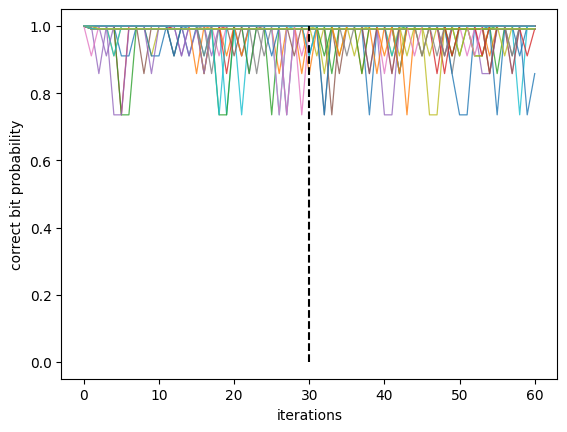

In [13]:
plt.plot(prob_traj_noFlip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train_long, n_it_train_long], [0, 1], "k--")

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_stability_long.png')

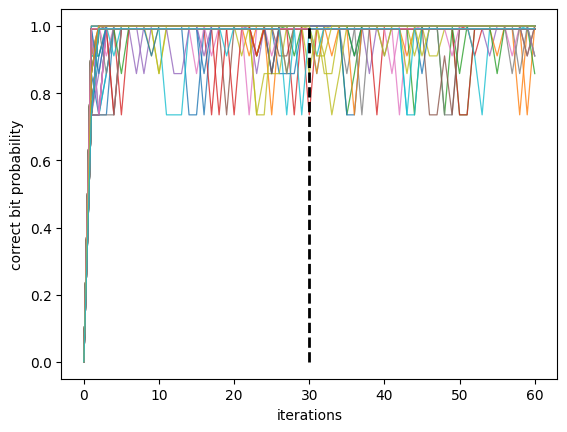

In [14]:
plt.plot(prob_traj_flip, linewidth=0.9, alpha=0.8)
plt.plot([n_it_train_long, n_it_train_long], [0, 1], "k--", linewidth=2)

plt.xlabel("iterations")
plt.ylabel("correct bit probability")
plt.savefig('rbm_bit_correction_long.png')

## RBM on Mnist

In [15]:
batch_size = 64
mnist_train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

In [16]:
n_it_training = 3

rbm_mnist = RBM(784, 500, n_it_training)
train_op = optim.SGD(rbm_mnist.parameters(),0.01)
losses=[]

n_epochs, n_batch = 10, 300
for epoch in range(n_epochs):
    loss_ = []
    for i, (data,target) in enumerate(mnist_train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1,p_v = rbm_mnist(sample_data)
        loss = rbm_mnist.free_energy(v) - rbm_mnist.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if i >= n_batch and n_batch > 0:
            break
        
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


Training loss for 0 epoch: -28.20506477355957
Training loss for 1 epoch: -16.420276641845703
Training loss for 2 epoch: -15.045944213867188
Training loss for 3 epoch: -15.14418888092041
Training loss for 4 epoch: -15.478259086608887
Training loss for 5 epoch: -15.804810523986816
Training loss for 6 epoch: -15.633252143859863
Training loss for 7 epoch: -15.53687572479248
Training loss for 8 epoch: -15.002656936645508
Training loss for 9 epoch: -14.425187110900879


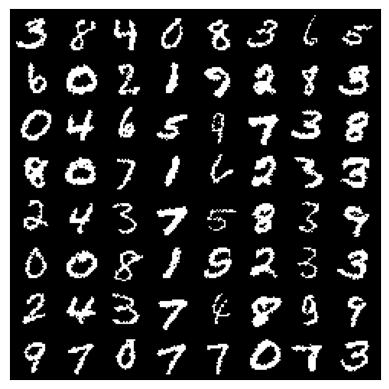

In [17]:
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

show_and_save("real_mnist",make_grid(v.view(-1,1,28,28).data))

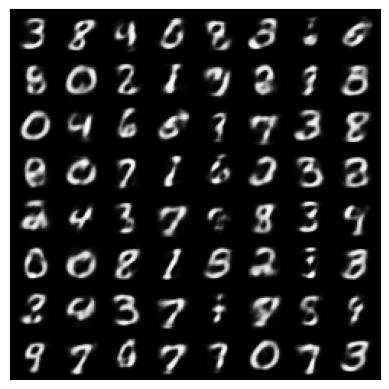

In [18]:
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

show_and_save("generate_mnist",make_grid(p_v.view(-1,1,28,28).data))

In [19]:
n_sample, n_its = 8, [1, rbm_mnist.k, 2*rbm_mnist.k, 100, 1000, 10000] 
data = torch.from_numpy(np.zeros((len(n_its)+1, 8, 784)).astype(np.single))

starting_data = np.zeros((8, 28, 28))
starting_data[0:4, 2:26, 2:26] = np.random.rand(4, 24, 24) > 0.9
starting_data[4:8, 5:23, 5:23] = np.random.rand(4, 18, 18) > 0.7

data[0, :, :] = torch.from_numpy(starting_data.reshape(8, 784).astype(np.single))

h_ = rbm_mnist.v_to_h(data[0, :, :])
for i in range(len(n_its)):
    n_it = n_its[i] - (0 if i == 0 else n_its[i - 1])
    for j in range(n_it):
        v_,p_v = rbm_mnist.h_to_v(h_)
        h_     = rbm_mnist.v_to_h(v_)
        data[i+1, :, :] = p_v

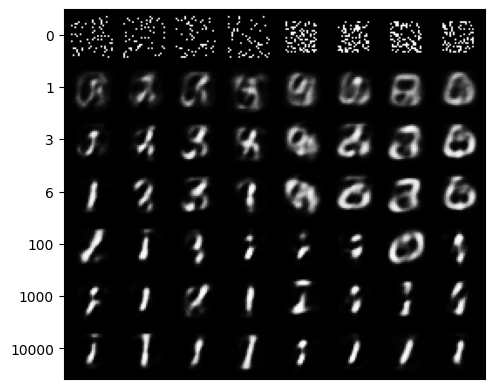

In [20]:
ax = plt.gca()
ax.set_yticks(14 + np.arange(0, len(n_its)+1)*30)
ax.set_yticklabels(["0"] + [str(n_it) for n_it in n_its])
ax.set_xticks([])

show_and_save("generate_mnist_steps", make_grid(data.data.view(-1,1,28,28)))

## Test on fashion mnist

In [21]:
batch_size = 32
fashion_train_loader = torch.utils.data.DataLoader(
datasets.FashionMNIST('./dataFashion',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

In [22]:
n_it_training = 2

rbm_fashion = RBM(784, 500, n_it_training)
train_op = optim.SGD(rbm_fashion.parameters(),0.01)
losses=[]

n_epochs, n_batch = 40, 500
for epoch in range(n_epochs):
    loss_ = []
    for i, (data,target) in enumerate(fashion_train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()

        sample_data = rbm_fashion.sample_from_p(sample_data.flatten()).reshape(sample_data.shape)
        
        v,v1,p_v = rbm_fashion(sample_data)
        loss = rbm_fashion.free_energy(v) - rbm_fashion.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()

        if i >= n_batch and n_batch > 0:
            break
    
    losses.append(np.mean(loss_))
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: -27.155467987060547
Training loss for 1 epoch: -20.90171241760254
Training loss for 2 epoch: -20.034076690673828
Training loss for 3 epoch: -18.530399322509766
Training loss for 4 epoch: -17.790067672729492
Training loss for 5 epoch: -16.73781394958496
Training loss for 6 epoch: -16.15777587890625
Training loss for 7 epoch: -15.634993553161621
Training loss for 8 epoch: -15.072574615478516
Training loss for 9 epoch: -14.448801040649414
Training loss for 10 epoch: -13.856874465942383
Training loss for 11 epoch: -13.190157890319824
Training loss for 12 epoch: -12.56108283996582
Training loss for 13 epoch: -12.235047340393066
Training loss for 14 epoch: -11.585026741027832
Training loss for 15 epoch: -11.001848220825195
Training loss for 16 epoch: -10.802059173583984
Training loss for 17 epoch: -10.045417785644531
Training loss for 18 epoch: -9.814759254455566
Training loss for 19 epoch: -9.40273666381836
Training loss for 20 epoch: -9.086223602294922
Training l

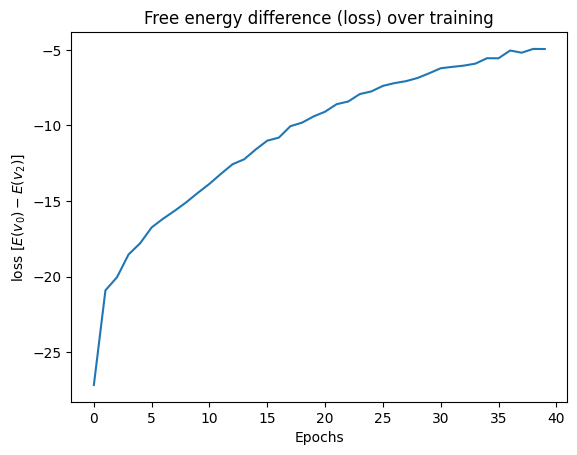

In [23]:
plt.plot(losses)
plt.title("Free energy difference (loss) over training")
plt.xlabel("Epochs")
plt.ylabel(rf"loss [$E(v_0) - E(v_{ n_it_training })$]")
plt.plot()
plt.savefig('free_energy_fashion.png')

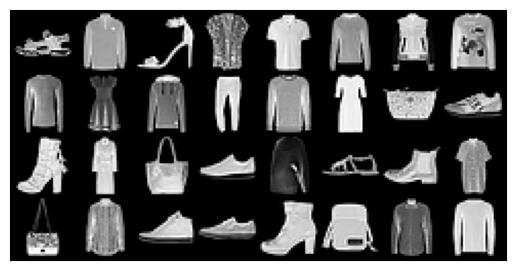

In [24]:
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

show_and_save("real_fashion", make_grid(data.data.view(-1,1,28,28)))

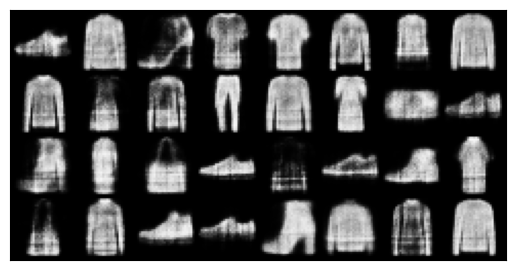

In [25]:
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

show_and_save("generate_fashion", make_grid(p_v.data.view(-1,1,28,28)))

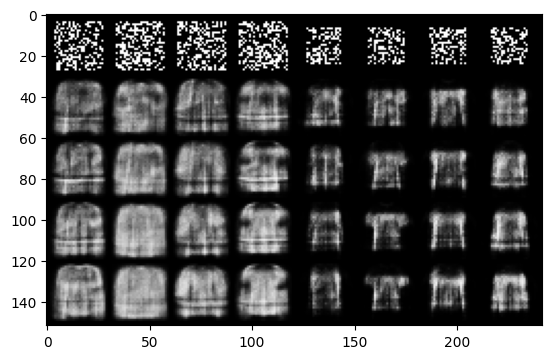

In [26]:
n_sample, n_it = 8, 2*n_it_training
data = torch.from_numpy(np.zeros((n_it+1, 8, 784)).astype(np.single))

starting_data = np.zeros((8, 28, 28))
starting_data[0:4, 2:26, 2:26] = np.random.rand(4, 24, 24) > 0.6
starting_data[4:8, 5:23, 5:23] = np.random.rand(4, 18, 18) > 0.6

data[0, :, :] = torch.from_numpy(starting_data.reshape(8, 784).astype(np.single))

h_ = rbm_fashion.v_to_h(data[0, :, :])
for i in range(n_it):
    v_,p_v = rbm_fashion.h_to_v(h_)
    h_     = rbm_fashion.v_to_h(v_)
    data[i+1, :, :] = p_v

show_and_save("generate_fashion_steps", make_grid(data.data.view(-1,1,28,28)))